In [1060]:
import pandas as pd
import random
import numpy as np
import gym
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd
import sys
import gym_gridworlds
#env = gym.make('Gridworld-v0')
  
from collections import defaultdict
import plottingepi
import matplotlib.pyplot as plt
#import plotting
import json
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind
import string

In [755]:
with open(r'wordle_words.json', mode='rb') as infile:
    word_list = json.load(infile)

In [793]:
word_list = [x.upper() for x in words_list]
len(word_list)

12972

In [763]:
np.where(word_df.word=="SHEAR")

(array([902], dtype=int64),)

In [848]:
class Wordle:
    def __init__(self, word=None, n_guesses=6, n_letters=5, all_words=['PROOF','SHEAR','BUMPY']):
        if word == None:
            self.word = random.sample(set(all_words[:2315]), 1)[0]
        else:
            self.word = word.upper()
        self.n_guesses = n_guesses
        self.n_letters = n_letters
        self.guess_counter = n_guesses
        self.greens = [None] * self.n_letters 
        self.current_yellows = [None] * self.n_letters
        self.yellows = {i: [] for i in range(self.n_letters)}
        self.guessed_words = []
        self.all_words = all_words
        self.absent_letters = []
        self.present_letters = []
        self.correct_positions = [None] * self.n_letters # greens would be differnt per guess, remember correct positions
        self.state = None
        self.gstate = [0] * self.n_letters
        self.ystate = [0]  * self.n_letters
        self.tmp_qstate = [0] * self.n_letters
        self.win = ''
        self.yellowlist = []
        self.totalgreens = [None]*self.n_letters
        self.totalyellows = [None]*self.n_letters
        
    def try_word (self, guess):
        # need to add a check for not doing anything if the word is already guessed correctly
        guess = guess.upper()
        self.state = None
        self.current_yellows = [None]* self.n_letters # yellows have to reset each time
        self.greens = [None] * self.n_letters
        self.tmp_qstate = [0] * self.n_letters
        
        print('guessed: ', guess)
        if not len(guess) == self.n_letters:
            raise ValueError('wrong word length')
        if guess not in self.all_words:
            raise ValueError('invalid word')
        if guess in self.guessed_words:
            raise ValueError('word already guessed')
        self.guessed_words.append(guess)
        # c_g = character_guess,  c_w = character_word
        for i, (c_g, c_w) in enumerate(zip(guess, self.word)):
            if c_g == c_w:
                self.greens[i] = c_g
                self.correct_positions[i] = c_g
                self.gstate[i] = 1
                self.tmp_qstate[i] = 1
            if c_g in self.word and c_g != c_w:
                self.yellows[i].append(c_g)
                self.current_yellows[i] = c_g
                if c_g not in self.yellowlist:
                    self.yellowlist += c_g
                self.ystate[i]=1
            if c_g in self.word: # track the letters that are there for the AI later
                self.present_letters.append(c_g)
            if c_g not in self.word: # track letters that are not there for the AI
                self.absent_letters.append(c_g)
            # Check for number of non-None in greens list 
            if sum(bool(char) for char in self.greens) == self.n_letters:
                self.state = True
                self.win ='win'
                print('victory! word is: ' + self.word) 
                grn_sum = sum([x!=None for x in self.greens])
                yel_sum = sum([x!=None for x in self.current_yellows])
                return grn_sum, yel_sum
        self.guess_counter -= 1
        grn_sum = sum([x!=None for x in self.greens])
        yel_sum = sum([x!=None for x in self.current_yellows])
        
        if self.guess_counter == 0:
            self.state=True
            self.win = 'lose'
            print("YOU LOSE-TOO MANY GUESSES")
            return grn_sum, yel_sum # return number of greens and number of yellows
        print('Greens:' + str(self.greens) + 
              '\nYellows: ' + str(self.yellows) + 
              '\nGuesses left: ' + str(self.guess_counter))

        return grn_sum, yel_sum # return number of greens and number of yellows
        

In [1059]:
print(len(word_list))

12972


In [766]:
w = Wordle(all_words = word_list)

In [767]:
w.word

'WEIRD'

In [768]:
w.try_word("CLEAN")

guessed:  CLEAN
Greens:[None, None, None, None, None]
Yellows: {0: [], 1: [], 2: ['E'], 3: [], 4: []}
Guesses left: 5


(0, 1)

In [769]:
w.yellows

{0: [], 1: [], 2: ['E'], 3: [], 4: []}

In [770]:
w.yellowlist

['E']

In [771]:
w.greens

[None, None, None, None, None]

In [1014]:
# player agent class
# try unknown letters

# need to add the ability to take the correct letters as input to the guess methods


## this is where we can have different 'types' of word guesses to be optimized
class Player:
    def __init__(self, all_words):
        self.guesses=0
        self.guessed_words = []
        self.all_words = all_words
        self.tmp_wordlist = []
        
    def get_random_guess(self):
        '''
        make a guess randomly from the word list
        '''       
        current_guess = random.sample(set(self.all_words), 1)[0]
        while(current_guess in self.guessed_words):
            current_guess = random.sample(set(self.all_words), 1)[0]
        self.guessed_words.append(current_guess)
        return current_guess
    #def get_common_guess(self):
    #    i=0
    #    while( self.all_words[i] in self.guessed_words):
    #        i+=1
    #    self.guessed_words.append(self.all_words[i])
    #    return self.all_words[i]
    
    def guess_by_green(self, GREENS):
        match_list=[]
        ALL_WORDS = self.all_words
        if not all(v is None for v in GREENS):
            for i, letter in enumerate(GREENS):
                match_list+=[word for word in ALL_WORDS if word[i]==letter]
                if letter is not None:
                    print(i)
                    ALL_WORDS = list(match_list)
                    match_list = []
            current_guess = random.sample(set(ALL_WORDS), 1)[0]
            # saw this fail on COUCH when it guessed COUGH
            while(current_guess in self.guessed_words):
                current_guess = random.sample(set(ALL_WORDS), 1)[0]
            self.guessed_words.append(current_guess)
            self.tmp_wordlist = ALL_WORDS
        else:
            current_guess = random.sample(set(self.all_words), 1)[0]
            while(current_guess in self.guessed_words):
                current_guess = random.sample(set(self.all_words), 1)[0]
            self.guessed_words.append(current_guess)
            self.tmp_wordlist = self.all_words
        return current_guess
    
    def guess_by_probs1(self): ## guess based on Ben's list
        ALL_WORDS = ['SAINT', 'CORED', 'BULKY', 'WHOMP']
        i=0
        while( ALL_WORDS[i] in self.guessed_words):
            i+=1
            if i==4:
                break
        if i<4: # if one of the first 4 guesses, then guess from this list, otherwise guess random
            current_guess = ALL_WORDS[i]
            self.guessed_words.append(ALL_WORDS[i])
        else:
            current_guess = random.sample(set(self.all_words), 1)[0]
            while(current_guess in self.guessed_words):
                current_guess = random.sample(set(self.all_words), 1)[0]
            self.guessed_words.append(current_guess)
        return current_guess
    
    def guess_by_probs2(self): ## guess based on Ben's list
        ALL_WORDS = ['MAMEE', 'SOILY', 'BRUNT', 'CHACK']
        i=0
        while( ALL_WORDS[i] in self.guessed_words):
            i+=1
            if i==4:
                break
        if i<4:
            current_guess = ALL_WORDS[i]
            self.guessed_words.append(ALL_WORDS[i])
        else:
            current_guess = random.sample(set(self.all_words), 1)[0]
            while(current_guess in self.guessed_words):
                current_guess = random.sample(set(self.all_words), 1)[0]
            self.guessed_words.append(current_guess)
        return current_guess
    
    def guess_exclude(self, ABSENT):
        ALL_WORDS = self.all_words
        ## remove any words with absent characters
        tmpstring = string.ascii_uppercase
        for letter in ABSENT:
            tmpstring=tmpstring.replace(letter, '')
        filtered_words = [word for word in ALL_WORDS if all([letter in tmpstring for letter in word])]    
        current_guess = random.sample(set(filtered_words), 1)[0]
        while(current_guess in self.guessed_words):
            current_guess = random.sample(set(filtered_words), 1)[0]
        self.guessed_words.append(current_guess)
        return current_guess
    
    def guess_smart(self, GREENS, ABSENT, YELLOWS, YL):
        match_list=[]
        ALL_WORDS = self.all_words
        if not all(v is None for v in GREENS): # check if the word has greens
            for i, letter in enumerate(GREENS):
                match_list+=[word for word in ALL_WORDS if word[i]==letter]
                if letter is not None:
                    print(i)
                    ALL_WORDS = list(match_list)
                    match_list = []
            ## remove any words with absent characters
            tmpstring = string.ascii_uppercase
            for letter in ABSENT:
                tmpstring=tmpstring.replace(letter, '')
            out = [word for word in ALL_WORDS if all([letter in tmpstring for letter in word])]        
            
            ## remove words that have yellow in that position
            #print('length of words b4 yellow:', len(out))
            aw = list(out)
            #print(len(aw))
            for key in YELLOWS.keys():
                #print(key)
                #print([w[key] for w in aw])
                for w in aw:
                    #print(w)
                    #print(YELLOWS[key])
                    if w[key] in YELLOWS[key]:
                        aw.remove(w)
            
            # add part that requires those yellows to be somewhere else in the word
            includeyel= []
            for w in aw:
                if all([substring in w for substring in YL]):
                    includeyel.append(w)
            #print(newlist)
            # saw this fail on COUCH when it guessed COUGH
            current_guess = random.sample(set(includeyel), 1)[0]
            while(current_guess in self.guessed_words):
                current_guess = random.sample(set(includeyel), 1)[0]
            self.guessed_words.append(current_guess)
            #self.tmp_wordlist = includeyel
            
            
        else:
            current_guess = random.sample(set(self.all_words), 1)[0]
            while(current_guess in self.guessed_words):
                current_guess = random.sample(set(self.all_words), 1)[0]
            self.guessed_words.append(current_guess)
            self.tmp_wordlist = self.all_words
        return current_guess

In [998]:
p = Player(word_list)

In [999]:
p.guess_by_green(['C', 'O', 'U', None, 'H'])

0
1
2
4


'COUTH'

In [1070]:
## need an environment class that lets the player interact with wordl
class Environment:
    REWARD_YELLOW = 2
    REWARD_GREEN = 5
    
    def __init__(self, WORD_LIST,STATE_TYPE, REWARD_WIN= 25, REWARD_LOSE= -15):
        self.reset(WORD_LIST)
        self.state_type = STATE_TYPE
        self.reward_win = REWARD_WIN
        self.reward_lose = REWARD_LOSE
    
    def reset(self, WORD_LIST):
        self.game_over = False
        self.score = 0
        self.player = Player(all_words = WORD_LIST)
        self.wordle = Wordle(all_words=WORD_LIST)
        print('+++++++++++++++++++++++++++++++')
        print('the wordl is:', self.wordle.word)
        print('_______________________________')
        self.guesses = 0
        self.action_space = [0,1,2,3,4]
        self.greens = [None, None, None, None, None]
        self.tmp_wordlist = []
        return (0, 0)
        
    def step(self, action):
        self.guesses += 1
        
        if action==0:
            current_guess = self.player.get_random_guess()
        elif action == 1:
            current_guess = self.player.guess_by_probs1()
        elif action == 2:
            current_guess = self.player.guess_by_probs2()
        elif action == 3:
            current_guess = self.player.guess_smart(self.wordle.greens, self.wordle.absent_letters,
                                                           self.wordle.yellows,
                                                           self.wordle.yellowlist)
        elif action == 4:
            current_guess = self.player.guess_exclude(self.wordle.absent_letters)
            
        n_greens, n_yellows = self.wordle.try_word(current_guess)
        reward = 0
        
        if n_greens>0:
            reward += self.REWARD_GREEN * n_greens
            self.score +=self.REWARD_GREEN
        if n_yellows>0:
            reward += self.REWARD_YELLOW * n_yellows
            self.score +=self.REWARD_YELLOW * n_yellows
        
        #self.tmp_wordlist = self.player.tmp_wordlist
        if self.state_type=='total':
            state = sum(self.wordle.gstate), sum(self.wordle.ystate)
        elif self.state_type =='last':
            state = (n_greens, n_yellows)
            
        if self.wordle.win == 'win':
            reward += self.reward_win
            self.score +=self.reward_win
            print('********* win reward: ', reward)
            result = self.wordle.tmp_qstate
            return state, reward, self.wordle.state
        
        if self.wordle.win == 'lose':
            reward = self.reward_lose
            self.score +=self.REWARD_WIN
            print('********* lose reward: ', reward)
            result = self.wordle.tmp_qstate
            return state, reward, self.wordle.state
        #result = self.wordle.tmp_qstate
        return state, reward, self.wordle.state
        
        

In [1071]:
e = Environment(WORD_LIST =word_list, STATE_TYPE='last')

+++++++++++++++++++++++++++++++
the wordl is: FLUNG
_______________________________


In [1074]:
e.step(2)

guessed:  MAMEE
Greens:[None, None, None, None, None]
Yellows: {0: [], 1: [], 2: [], 3: [], 4: []}
Guesses left: 5


((0, 0), 0, None)

In [786]:
#from stable_baselines.common.policies import MlpPolicy
#from stable_baselines.common.vec_env import DummyVecEnv
#from stable_baselines import PPO1

In [1004]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
	"""
	Creates an epsilon-greedy policy based
	on a given Q-function and epsilon.
	
	Returns a function that takes the state
	as an input and returns the probabilities
	for each action in the form of a numpy array
	of length of the action space(set of possible actions).
	"""
	def policyFunction(state):

		Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
		best_action = np.argmax(Q[state])
		Action_probabilities[best_action] += (1.0 - epsilon)
		return Action_probabilities

	return policyFunction


In [1005]:
e.action_space

[0, 1, 2, 3, 4]

In [1018]:
def qLearning(env, num_episodes, discount_factor = 1.0, alpha = 0.5, epsilon = 0.3, prints=False):
    """
    Q-Learning algorithm: Off-policy TD control.
    Finds the optimal greedy policy while improving
    following an epsilon-greedy policy"""
    
    # Action value function
    # A nested dictionary that maps
    # state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(len(env.action_space)))
    # Keeps track of useful statistics
    stats = plottingepi.EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes))
    win_records = np.zeros(num_episodes)
    
    # Create an epsilon greedy policy function
    # appropriately for environment action space
    policy = createEpsilonGreedyPolicy(Q, epsilon, len(env.action_space) )
    wordlistdict = defaultdict()
    
    # For every episode
    for ith_episode in range(num_episodes):

        # Reset the environment and pick the first action
        state = env.reset(word_list)
        
        for t in itertools.count():
            #print("this is q", Q)
            # get probabilities of all actions from current state
            action_probabilities = policy(state)
            if prints: print('action probabilities:', action_probabilities)
            # choose action according to
            # the probability distribution
            action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)
            if prints: print('taking action #: ', action)
            # take action and get reward, transit to next state
            next_state, reward, done = env.step(action)
            if prints: print('current state is: ',state)
            if prints: print('next state is:', next_state )
            
            #next_state = sum(next_state)
            
            # Update statistics
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = t
            if(env.wordle.win =='win'):
                win_records[ith_episode] = 1
            elif(env.wordle.win == 'lose'):
                win_records[ith_episode] = 0
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])	
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            

            # done is True if episode terminated
            if done:
                break

            state = next_state
        #wordlistdict[env.wordle.word] = env.tmp_wordlist
            
    return Q, stats, win_records


In [1019]:
'CORED' in word_list

True

In [1021]:
# qouts1 is using state = 'last' 1000 iter , epsilon=0.3,alpha=0.02, discount_factor=0.05
# qouts 2 uses state 'total', 1000 iter , epsilon=0.3,alpha=0.02, discount_factor=0.05
# qouts 3 uses state 'last', 10000 iter , epsilon=0.3,alpha=0.02, discount_factor=0.05
# qouts 4 uses state 'total', 10000 iter , epsilon=0.3,alpha=0.02, discount_factor=0.05
# qouts 5 uses state 'last', 10000 iter , epsilon=0.02,alpha=0.02, discount_factor=0.05,
# 6 uses state 'last' added new option probs 2,  10000, epsilon=0.3,alpha=0.02, discount_factor=0.05, prints=False)
# 7 uses state 'total' added new option probs 2,  10000, epsilon=0.3,alpha=0.02, discount_factor=0.05, prints=False)
# 8 uses state last, 'total' added new option probs 2,  10000, epsilon=0.02,alpha=0.02, discount_factor=0.05, prints=False)
# 9 uses state last, 'total' added new option probs 2,  10000, epsilon=0.5,alpha=0.02, discount_factor=0.05, prints=False)


In [ ]:

qouts9 = []
souts9 = []
wouts9 = []
for i in range(0,3):
    print(i)
    tmpq, tmps, tmpw = qLearning(Environment(WORD_LIST=word_list, STATE_TYPE='last'), 
                           10000, epsilon=0.5,alpha=0.02, discount_factor=0.05, prints=False)
    qouts9.append(tmpq)
    souts9.append(tmps)
    wouts9.append(tmpw)
print(np.mean([sum(x) for x in wouts1]))

In [1061]:
print(np.mean([sum(x) for x in wouts6]))
print(np.std([sum(x) for x in wouts6]))

4969.666666666667
82.70966623611106


In [1062]:
print(np.mean([sum(x) for x in wouts7]))
print(np.std([sum(x) for x in wouts7]))


4664.0
109.8453458276681


In [1063]:
print(np.mean([sum(x) for x in wouts8]))
print(np.std([sum(x) for x in wouts8]))

6313.333333333333
722.1608008070102


In [1064]:
print(np.mean([sum(x) for x in wouts9]))
print(np.std([sum(x) for x in wouts9]))

3599.0
47.42010825237187


In [1065]:
ttest_ind([sum(x) for x in wouts6], [sum(x) for x in wouts7], equal_var=False)

Ttest_indResult(statistic=3.14378648640506, pvalue=0.03842433999248083)

In [988]:
np.mean([sum(x) for x in wouts5])

5376.666666666667

In [909]:
def win_trace(input):
    summed = []
    i=0
    for x in input:
        if x==1:
            i+=x
            summed.append(i)
        else:
            summed.append(i)
    return summed

0
1
2
3
4
5


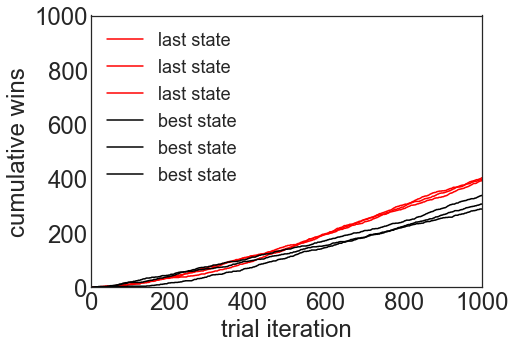

In [1040]:
# best state = black
plt.rcParams['figure.figsize']=7,5
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
plt.style.use('seaborn-white')
colors = ['red']*3+['black']*3
for i in range(0,6):
    print(i)
    if i<3:
        plt.plot(win_trace(wouts6[i]),color=colors[i])
        plt.ylim(0,1000)
        plt.xlim(0,1000)
    else:
        plt.plot(win_trace(wouts7[i-3]),color=colors[i])
plt.xlabel('trial iteration', fontsize=24)
plt.ylabel('cumulative wins', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(['last state']*3+['best state']*3, fontsize=18)
plt.savefig('plots/last_versus_best_state1000.svg', bbox_inches='tight')

# Policy heatmap, epsilon = 0.5

In [1048]:
qdf = pd.concat([pd.DataFrame.from_dict(qouts9[0], orient='index', columns=['random', 'probs1','probs2', 'smart', 'exclude']).sort_index(),
           pd.DataFrame.from_dict(qouts9[1], orient='index', columns=['random', 'probs1','probs2', 'smart', 'exclude']).sort_index(),
           pd.DataFrame.from_dict(qouts9[2], orient='index', columns=['random', 'probs1','probs2', 'smart', 'exclude']).sort_index()]).groupby(level=0).mean()
qdf

,random,probs1,probs2,smart,exclude
"(0, 0)",3.309916,3.462410,3.580568,2.995440,3.343786
"(0, 1)",1.494802,2.475084,1.772137,1.782081,3.466182
"(0, 2)",0.356178,1.370072,2.136370,1.319162,2.599980
"(0, 3)",0.446029,1.131661,0.408917,0.828309,2.113133
"(0, 4)",-2.260330,-1.527374,-1.860755,-1.412613,-1.136917
"(0, 5)",-0.319760,0.128670,-0.431002,-0.284692,-0.057583
"(1, 0)",1.443965,3.015195,2.320005,13.603151,3.718746
"(1, 1)",1.533807,2.378456,2.367313,14.929076,4.845253
"(1, 2)",1.918895,1.371430,1.911050,18.993001,3.524739
"(1, 3)",-0.630706,0.217045,-0.215766,23.471355,1.908255


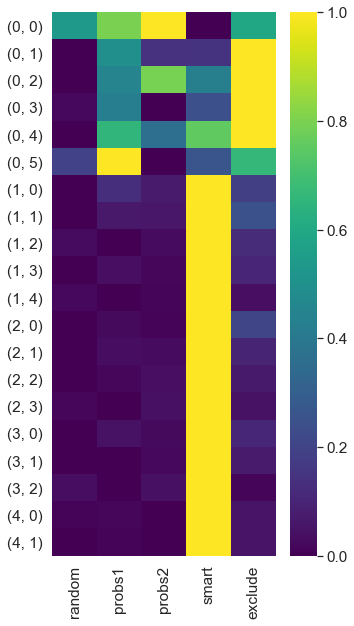

In [1049]:
qdft = pd.DataFrame(MinMaxScaler().fit_transform(qdf.T).T, columns=qdf.columns, index=qdf.index)
qdft.drop(qdft.tail(1).index,inplace=True)

plt.rcParams['figure.figsize'] = 5,10
sns.set(font_scale=1.4)
ax = sns.heatmap(qdft, cmap='viridis')
#plt.title('Optimal Policy (Normalized)', fontsize=20)
plt.savefig('plots/policy_heatmap_0p5e.svg')

# Policy heatmap, epsilon = 0.02

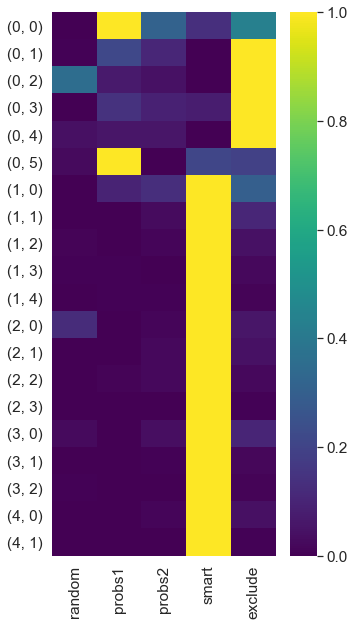

In [1057]:
qdf = pd.concat([pd.DataFrame.from_dict(qouts8[0], orient='index', columns=['random', 'probs1','probs2', 'smart', 'exclude']).sort_index(),
           pd.DataFrame.from_dict(qouts8[1], orient='index', columns=['random', 'probs1','probs2', 'smart', 'exclude']).sort_index(),
           pd.DataFrame.from_dict(qouts8[2], orient='index', columns=['random', 'probs1','probs2', 'smart', 'exclude']).sort_index()]).groupby(level=0).mean()

qdft = pd.DataFrame(MinMaxScaler().fit_transform(qdf.T).T, columns=qdf.columns, index=qdf.index)
qdft.drop(qdft.tail(1).index,inplace=True)

plt.rcParams['figure.figsize'] = 5,10
sns.set(font_scale=1.4)
ax = sns.heatmap(qdft, cmap='viridis')
#plt.title('Optimal Policy (Normalized)', fontsize=20)
plt.savefig('plots/policy_heatmap_0p02e.svg')

In [960]:
#policy for 10k iter, total state
pd.concat([pd.DataFrame.from_dict(qouts5[0], orient='index', columns=['random', 'probs', 'smart', 'exclude']).sort_index(),
           pd.DataFrame.from_dict(qouts5[1], orient='index', columns=['random', 'probs', 'smart', 'exclude']).sort_index(),
           pd.DataFrame.from_dict(qouts5[2], orient='index', columns=['random', 'probs', 'smart', 'exclude']).sort_index()]).groupby(level=0).mean()

,random,probs,smart,exclude
"(0, 0)",3.052967,4.700094,3.013923,3.114437
"(0, 1)",3.441211,2.031658,1.202999,3.590128
"(0, 2)",0.723738,3.266978,1.168394,3.519345
"(0, 3)",0.132481,1.534980,0.718171,5.304660
"(0, 4)",0.163312,-0.121055,-0.423408,5.299389
"(0, 5)",-2.378672,-2.397461,-2.360895,1.473453
"(1, 0)",3.615351,1.135064,0.952773,0.876771
"(1, 1)",1.572897,2.149399,7.982457,1.612615
"(1, 2)",1.009681,1.326893,6.001651,5.149132
"(1, 3)",0.488276,0.436046,15.348056,1.374688


Ttest_indResult(statistic=4.564277855507594, pvalue=0.02535871981045415)

In [1066]:
## count of times hitting on first or second guess
print('num wins on first try:', len(np.where(souts8[0].episode_lengths+1==1)[0]))
print('num wins on second try:', len(np.where(souts8[0].episode_lengths+1==2)[0]))
print('num wins on third try:', len(np.where(souts8[0].episode_lengths+1==3)[0]))


num wins on first try: 1
num wins on second try: 103
num wins on third try: 832


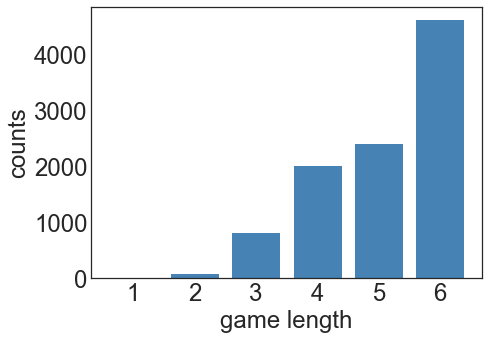

In [1054]:
import seaborn as sns
plt.rcParams['figure.figsize']=7,5
plt.style.use('seaborn-white')
#plt.rcParams['axes.facecolor']='white'
#plt.rcParams["axes.edgecolor"] = "black"
#plt.rcParams["axes.linewidth"] = 2
labels, counts = np.unique(souts8[0].episode_lengths+1, return_counts=True)
plt.bar(labels, counts, align='center', color='steelblue')

#plt.hist(s1.episode_lengths+1, bins=10, align='mid')
#plt.title('10,000 trials', fontsize=24)
plt.xlabel('game length', fontsize=24)
plt.ylabel('counts', fontsize=24)
plt.gca().set_xticks(labels)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.savefig('plots/game_lengths_10k.svg', bbox_inches='tight')

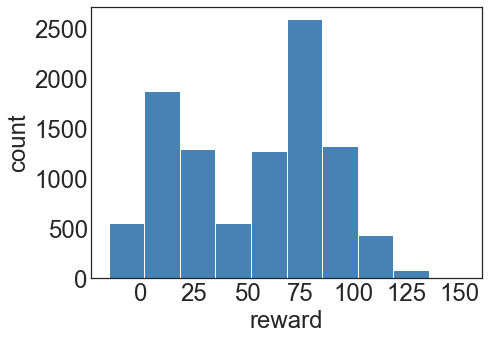

In [1055]:
tmphist = plt.hist(souts3[0].episode_rewards, color='steelblue')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('count', fontsize=24)
plt.xlabel('reward', fontsize=24)
#plt.title('10,000 trials', fontsize=24)
plt.savefig('plots/rewards-distro_10k.svg', bbox_inches='tight')